In [1]:
# Importing libraries
import pandas as pd
from pathlib import Path
import requests
import json
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from scipy.stats import linregress
import plotly.express as px
import seaborn as sns
import matplotlib as cm

# Import the API key
from config import geoapify_key

ModuleNotFoundError: No module named 'config'

In [2]:
# Importing data
censorship_data_csv = Path("Resources/Censorship_Data_by_Country.csv")
population_data_csv = Path("Resources/Country_Population_2023.csv")

# Reading data
censorship_data = pd.read_csv(censorship_data_csv,encoding='utf-8')
population_data = pd.read_csv(population_data_csv,encoding='utf-8')

In [3]:
# Inspecting data for Censorship
censorship_data.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions
0,:af:,Afghanistan,6,Y,N,Y,Y,Y,Y,Y,N,N,N,N
1,:al:,Albania,2,Y,N,N,N,Y,N,N,N,N,N,N
2,:dz:,Algeria,5,Y,N,Y,N,Y,Y,Y,N,N,N,N
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N
4,:ao:,Angola,2,Y,N,N,N,Y,N,N,N,N,N,N


In [4]:
# Inspecting data for Population
population_data.head()

,#,Country (or dependency),Population (2023)
0,1,India,"1,428,627,663"
1,2,China,"1,425,671,352"
2,3,United States,"339,996,563"
3,4,Indonesia,"277,534,122"
4,5,Pakistan,"240,485,658"


In [5]:
# Cleaning and Renaming Population Data
population_data = population_data.rename(columns={"Country (or dependency)":"Country"})
population_data = population_data.drop(columns=["#"])
population_data.head()


,Country,Population (2023)
0,India,"1,428,627,663"
1,China,"1,425,671,352"
2,United States,"339,996,563"
3,Indonesia,"277,534,122"
4,Pakistan,"240,485,658"


In [6]:
# Merging Censorship and Population
all_data = pd.merge(censorship_data, population_data, on="Country", how="left")
all_data.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions,Population (2023)
0,:af:,Afghanistan,6,Y,N,Y,Y,Y,Y,Y,N,N,N,N,"42,239,854"
1,:al:,Albania,2,Y,N,N,N,Y,N,N,N,N,N,N,"2,832,439"
2,:dz:,Algeria,5,Y,N,Y,N,Y,Y,Y,N,N,N,N,"45,606,480"
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N,"80,088"
4,:ao:,Angola,2,Y,N,N,N,Y,N,N,N,N,N,N,"36,684,202"


In [7]:
# Checking for blank values
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Flag                                 175 non-null    object
 1   Country                              175 non-null    object
 2   Score                                175 non-null    int64 
 3   Torrents Restricted?                 175 non-null    object
 4   Torrents Banned or Shut Down?        175 non-null    object
 5   Pornography Restricted?              175 non-null    object
 6   Pornography Banned?                  175 non-null    object
 7   Political Media Restricted?          175 non-null    object
 8   Political Media Heavily Censored?    175 non-null    object
 9   Social Media Restricted?             175 non-null    object
 10  Social Media Banned?                 175 non-null    object
 11  VPNs Restricted                      175 non-

In [8]:
# Updating the population data from dtype object to dtype numerical
all_data["Population (2023)"] = pd.to_numeric(all_data["Population (2023)"].str.replace(',',''), errors='coerce')

In [9]:
# High level overview of data table
all_data.describe()

,Score,Population (2023)
count,175.000000,1.750000e+02
mean,3.565714,4.576643e+07
std,2.332916,1.573452e+08
min,1.000000,3.958400e+04
25%,2.000000,3.441544e+06
50%,3.000000,1.041265e+07
75%,5.000000,3.440421e+07
max,11.000000,1.428628e+09


In [10]:
# Extract Country into a list
country_list = list(all_data["Country"])
print(country_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo-Brazzaville', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana ', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait

In [38]:
# Geoapify Base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [39]:
# Prepare a list to hold the results
results = []

# Loop through the country list and get coordinates
for country in country_list:
    
    # Set up the parameters for the request
    params = {
        'country': country,
        'apiKey': geoapify_key,
        'limit': 1  # We only want the first (most relevant) result
    }
    
    # Make the request to the Geoapify API
    response = requests.get(base_url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:

        # Parse the response JSON to get the coordinates
        data = response.json()
        if data['features']:

            # Usually, the first feature in the list is the most relevant
            feature = data['features'][0]
            coordinates = feature['geometry']['coordinates']
            region = feature['properties']['timezone']

            # Add the country and its coordinates to the results list
            results.append({
                'Country': country,
                'Latitude': coordinates[1],
                'Longitude': coordinates[0],
                'Region': region['name']
            })
        else:
            print(f'No results found for {country}')
    else:
        print(f'Failed to get coordinates for {country}: HTTP {response.status_code}')

# Create a DataFrame from the results
df_coordinates = pd.DataFrame(results)

# Display the DataFrame
df_coordinates.head()


,Country,Latitude,Longitude,Region
0,Afghanistan,33.768006,66.238514,Asia/Kabul
1,Albania,41.000028,19.999962,Europe/Tirane
2,Algeria,28.000027,2.999983,Africa/Algiers
3,Andorra,42.540717,1.573203,Europe/Andorra
4,Angola,-11.877577,17.569124,Africa/Luanda


In [40]:
# Splitting the 'Region' column at '/' and keeping only the first part
df_coordinates['Region'] = df_coordinates['Region'].str.split('/').str[0]
df_coordinates.head()

,Country,Latitude,Longitude,Region
0,Afghanistan,33.768006,66.238514,Asia
1,Albania,41.000028,19.999962,Europe
2,Algeria,28.000027,2.999983,Africa
3,Andorra,42.540717,1.573203,Europe
4,Angola,-11.877577,17.569124,Africa


In [41]:
# Merging Censor Data, with Coordinates Data
final_df = pd.merge(all_data, df_coordinates, on="Country", how="inner")
final_df.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions,Population (2023),Latitude,Longitude,Region
0,:af:,Afghanistan,6,Y,N,Y,Y,Y,Y,Y,N,N,N,N,42239854,33.768006,66.238514,Asia
1,:al:,Albania,2,Y,N,N,N,Y,N,N,N,N,N,N,2832439,41.000028,19.999962,Europe
2,:dz:,Algeria,5,Y,N,Y,N,Y,Y,Y,N,N,N,N,45606480,28.000027,2.999983,Africa
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N,80088,42.540717,1.573203,Europe
4,:ao:,Angola,2,Y,N,N,N,Y,N,N,N,N,N,N,36684202,-11.877577,17.569124,Africa


In [42]:
# Initialize a map:
map = folium.Map(location=[final_df['Latitude'].mean(), final_df['Longitude'].mean()], zoom_start=2)

# Create heat_data list with Latitude, Longitude and Score as weight
heat_data = [[row['Latitude'], row['Longitude'], row['Score']] for index, row in final_df.iterrows()]

# Add heat map layer to the map:
heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=0.25, radius=50, blur=15, 
                  max_zoom=1, use_local_extrema=True)
map.add_child(heatmap)

# Iterate over each row of the DataFrame and add a CircleMarker
for idx, row in final_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=9, # Small radius for the marker
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=folium.Popup(f"Country: {row['Country']}<br>Region: {row['Region']}<br>Score: {row['Score']}<br>Population: {row['Population (2023)']}", max_width=300)
    ).add_to(map)



display(map)

C:\Users\Haylee\AppData\Local\Temp\ipykernel_16920\3222365246.py:8: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heatmap = HeatMap(heat_data, max_val=max(final_df['Score']), min_opacity=0.25, radius=50, blur=15,


In [68]:
# Initialize a map
map = folium.Map(location=[final_df['Latitude'].mean(), final_df['Longitude'].mean()], zoom_start=2)

# Create heat_data list with Latitude, Longitude and Score as weight
heat_data = [[row['Latitude'], row['Longitude'], int(row['Population (2023)']*row['Score'])] for index, row in final_df.iterrows()]

# Add heat map layer to the map
heatmap = HeatMap(heat_data, max_val=max(final_df['Population (2023)']*final_df['Score']), min_opacity=.25, radius=60, blur=15, 
                  max_zoom=1, use_local_extrema=True)
map.add_child(heatmap)

# Iterate over each row of the DataFrame and add a CircleMarker
for idx, row in final_df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=folium.Popup(f"Country: {row['Country']}<br>Region: {row['Region']}<br>Score: {row['Score']}<br>Population: {row['Population (2023)']}", max_width=300)
    ).add_to(map)

# Display the map
display(map)

C:\Users\Haylee\AppData\Local\Temp\ipykernel_16920\4130070257.py:8: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heatmap = HeatMap(heat_data, max_val=max(final_df['Population (2023)']*final_df['Score']), min_opacity=.25, radius=60, blur=15,


In [45]:
# Describing the countries by region 
region_count = final_df.groupby("Region")['Score'].agg(['count','sum','mean','median','min','max','var','std']).reset_index()
region_stats = region_count.rename(columns={"count":"Countries Total", "sum":"Score Total"})
region_stats.head(9)

,Region,Countries Total,Score Total,mean,median,min,max,var,std
0,Africa,48,165,3.437500,3.0,1,7,2.166223,1.471810
1,America,24,58,2.416667,2.0,1,7,2.601449,1.612901
2,Asia,49,286,5.836735,6.0,1,11,5.847789,2.418220
3,Atlantic,2,3,1.500000,1.5,1,2,0.500000,0.707107
4,Australia,1,3,3.000000,3.0,3,3,NaN,NaN
5,Europe,41,85,2.073171,2.0,1,8,2.419512,1.555478
6,Indian,5,12,2.400000,3.0,1,3,0.800000,0.894427
7,Pacific,5,12,2.400000,2.0,1,4,1.300000,1.140175


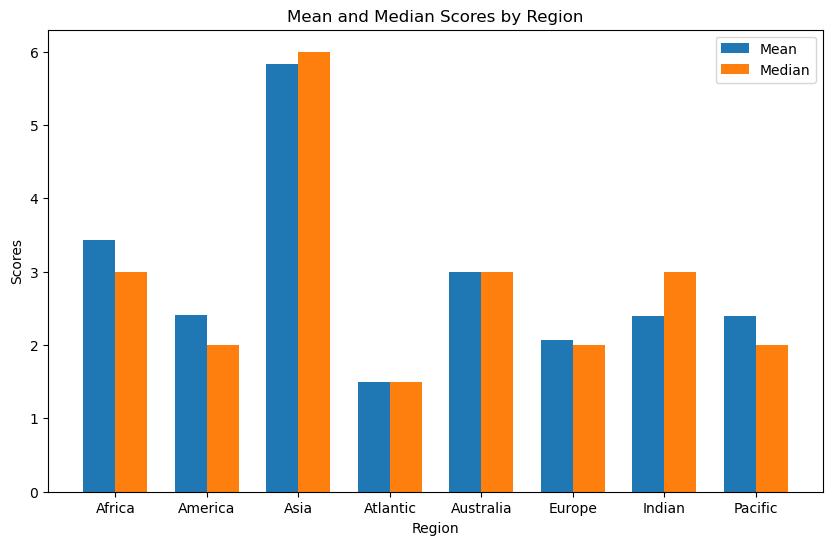

In [46]:
# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(region_stats))

bar1 = ax.bar(index, region_stats['mean'], bar_width, label='Mean', color='#2252a3', edgecolor= 'black')
bar2 = ax.bar([i + bar_width for i in index], region_stats['median'], bar_width, label='Median', color= '#88aad9', edgecolor= 'black')

ax.set_xlabel('Region')
ax.set_ylabel('Scores')
ax.set_title('Mean and Median Scores by Region')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(region_stats['Region'])
ax.legend()

plt.show()

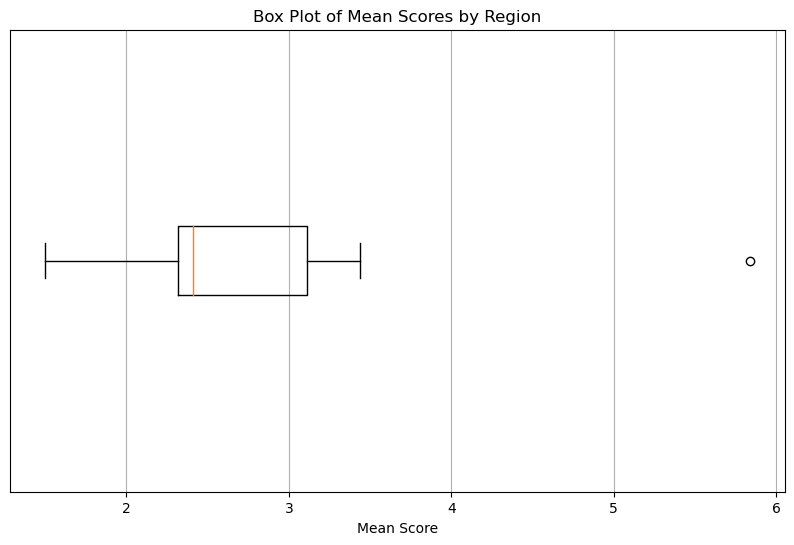

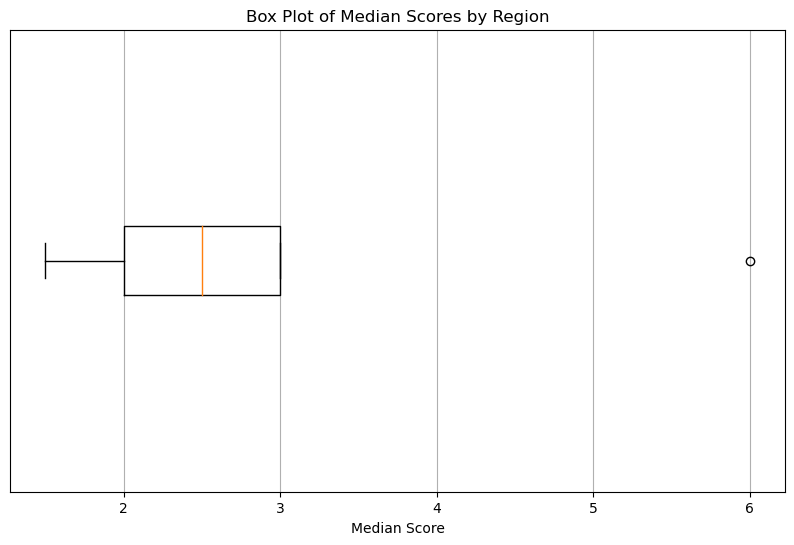

In [47]:
# Create a box plot for Mean scores by region
plt.figure(figsize=(10, 6))
plt.boxplot(region_stats['mean'], vert=False)
plt.title('Box Plot of Mean Scores by Region')
plt.xlabel('Mean Score')
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x')
plt.show()

# Create a box plot for Median scores by region
plt.figure(figsize=(10, 6))
plt.boxplot(region_stats['median'], vert=False)
plt.title('Box Plot of Median Scores by Region')
plt.xlabel('Median Score')
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x')
plt.show()

In [48]:
# Sorting by population size for charts
all_data = all_data.sort_values(by=["Population (2023)"])

In [49]:
# Creating bins and names to hold the data
bins = [0, 1_000_000, 5_000_000, 10_000_000, 15_000_000, 20_000_000, 50_000_000, 100_000_000, 1_000_000_000, 1_500_000_000]

# Creating labels for population range
group_names = ["Below 1 Million","1M-5M","5-10M","10-15M", "15-20M", "20-50M", "50-100M", "100M-1B","Above 1 Billion"]

In [50]:
# Slice data and place into bins
all_data["Population Range"] = pd.cut(all_data["Population (2023)"],
                                       bins, labels = group_names,
                                       include_lowest= True, ordered= True)

all_data.head()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions,Population (2023),Population Range
90,:li:,Liechtenstein,1,Y,N,N,N,N,N,N,N,N,N,N,39584,Below 1 Million
3,:ad:,Andorra,1,Y,N,N,N,N,N,N,N,N,N,N,80088,Below 1 Million
136,:sc:,Seychelles,1,Y,N,N,N,N,N,N,N,N,N,N,107660,Below 1 Million
158,:to:,Tonga,2,Y,N,N,N,Y,N,N,N,N,N,N,107773,Below 1 Million
132,:ws:,Samoa,2,Y,N,N,N,Y,N,N,N,N,N,N,225681,Below 1 Million


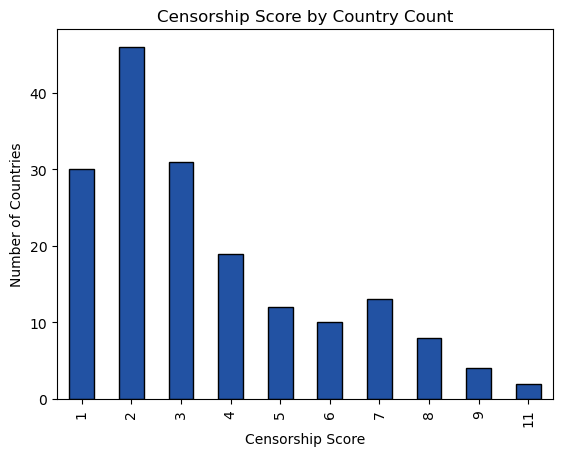

In [11]:
# Bar Chart of Censorship Score and Number of Countries
# 1 is least censored and 11 is most censored
# Country Score Counts
score_counts = all_data["Score"].value_counts().sort_index()

# Bar Graph
score_counts.plot(kind='bar', color='#2252a3', edgecolor= 'black')
plt.xlabel('Censorship Score')
plt.ylabel('Number of Countries')
plt.title('Censorship Score by Country Count')
plt.show()

In [14]:
# Bar Chart of Censorship Score and Country Population 
# 1 is least censored and 11 is most censored
# Create a bar chart
plt.bar(all_data["Population Range (2023)"], all_data["Score"], color='#2252a3', edgecolor= 'black', bar_width= 2)
plt.xlabel("Population Range")
plt.xticks(rotation=315)
plt.ylabel("Censorship Score")
plt.title('Censorship Score by Population Range')
plt.show()

KeyError: 'Population Range (2023)'

The r-squared is: 0.10052119235685048


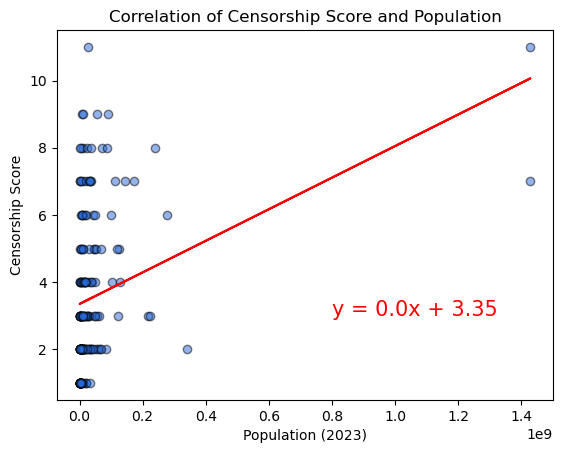

In [16]:
# Correlation between population and level of censorship 
# 1 is least censored and 11 is most censored
x_values = all_data["Population (2023)"]
y_values = all_data["Score"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="#2869d7", alpha= 0.5, edgecolor= 'black')
plt.plot(x_values,regress_values,"r-")
plt.title("Correlation of Censorship Score and Population")
plt.annotate(line_eq,(800_000_000,3),fontsize=15,color="red")
plt.xlabel("Population (2023)")
plt.ylabel("Censorship Score")
print(f"The r-squared is: {rvalue**2}")
plt.show()

TypeError: Axes.boxplot() got an unexpected keyword argument 'color'

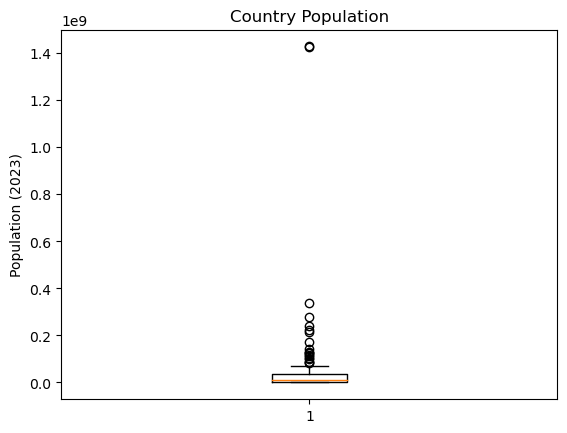

In [19]:
# Box and whisker plot to determine population outliers
fig1, ax1 = plt.subplots()
ax1.set_title("Country Population")
ax1.set_ylabel("Population (2023)")
ax1.boxplot(x_values)

# Generate a list of outliers
boxplot = ax1.boxplot(x_values, color="#2869d7", alpha= 0.5, edgecolor= 'black') #look into colors
outliers = [flier.get_ydata() for flier in boxplot['fliers']]
plt.show()

print(print("Outliers:", outliers))

In [55]:
# Filtering outliers from data table
remove_outliers = all_data.loc[all_data["Population (2023)"] < 83294633]
remove_outliers.tail()

,Flag,Country,Score,Torrents Restricted?,Torrents Banned or Shut Down?,Pornography Restricted?,Pornography Banned?,Political Media Restricted?,Political Media Heavily Censored?,Social Media Restricted?,Social Media Banned?,VPNs Restricted,VPNs Banned?,Messaging and VoIP App Restrictions,Population (2023),Population Range
142,:za:,South Africa,3,Y,Y,Y,N,N,N,N,N,N,N,N,60414495,50-100M
55,:fr:,France,2,Y,Y,N,N,N,N,N,N,N,N,N,64756584,50-100M
154,:tz:,Tanzania,5,Y,N,Y,Y,Y,N,Y,N,N,N,N,67438106,50-100M
166,:gb:,United Kingdom,2,Y,Y,N,N,N,N,N,N,N,N,N,67736802,50-100M
155,:th:,Thailand,8,Y,Y,Y,Y,Y,Y,Y,N,Y,N,N,71801279,50-100M


In [20]:
# Correlation between population and level of censorship without outliers
# 1 is least censored and 11 is most censored
x_values = remove_outliers["Population (2023)"]
y_values = remove_outliers["Score"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values, color="#2869d7", alpha= 0.5, edgecolor= 'black')
plt.plot(x_values,regress_values,"r-")
plt.title("Correlation of Censorship Score and Population without Outliers")
plt.annotate(line_eq,(500_000,10),fontsize=15,color="red")
plt.xlabel("Population (2023)")
plt.ylabel("Censorship Score")
print(f"The r-squared is: {rvalue**2}")
plt.show()

NameError: name 'remove_outliers' is not defined

## Findings
After cleaning the original data we added a few additional data sets (population and region) to look at censorship globally. Then we drilled down into internet censorship by population and region to determine who is censoring their internet the most and whether having a large population matters with level of censorship. Overall, we found that Asia is the most censored region with North Korea and China having the heaviest censorship by banning all factors of internet assessed. Whereas, the Atlantic region is the least censored with Cape Verde and Iceland having the lowest censorship scores. When analyzing the data there seemed to be a relationship between population and censorship. In the bar chart titled Censorship Score by Population Range, you can see that as population goes up so does the censoredship score. Initially charting a scatter plot between population and censorship score it shows a weak correlation with an R-squared value of 0.1. However, since both India and China have such large populations (greater than 1 billion) it is probably that their influence is skewing the data. To determine this, a box and whisker plot was used to understand which country populations are outliers. Removing those countries from the data set and re-plotting the scatter plot the correlation drops further suggesting that the two large populations were creating what seemed to be a correlation when there actually is none.
It was surprising to see that every country had at least one category restricted or censored and no country was completely free of internet regulations. 